<a href="https://colab.research.google.com/github/SamMilnes/Weather-Prediction-Models-By-Country/blob/main/Analysis_By_Country.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
all_countries = pd.read_csv('/content/gdrive/MyDrive/Data Science Group Project/GlobalLandTemperaturesByCountry.csv')
len(all_countries)
# all_countries["Country"].unique()

577462

In [3]:
united_states = all_countries[all_countries["Country"] == "United States"]
afghanistan = all_countries[all_countries["Country"] == "Afghanistan"]
bangladesh = all_countries[all_countries["Country"] == "Bangladesh"]
chad = all_countries[all_countries["Country"] == "Chad"]
haiti = all_countries[all_countries["Country"] == "Haiti"]

In [4]:
lst = [united_states, afghanistan, bangladesh, chad, haiti]
lst_string = ["United States", "Afghanistan", "Bangladesh", "Chad", "Haiti"]
for i in range(0, len(lst)):
  print(lst_string[i], "dataframe has", len(lst[i]), "rows")

United States dataframe has 2941 rows
Afghanistan dataframe has 2106 rows
Bangladesh dataframe has 2613 rows
Chad dataframe has 1893 rows
Haiti dataframe has 2277 rows


# LSTM Time Series Models For Each Country

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.callbacks import History
from tensorflow.keras.models import load_model

In [6]:
# This function is used to make our LSTM Models for each country
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+5]]
    X.append(row)
    label = df_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [7]:
# This function will be used to clean the dataframes, ie drop na values and get only the date and temperture columns
def clean_df(df):
  temp = df.copy()
  temp = temp[["dt", "AverageTemperature"]]
  temp = temp.dropna()
  temp["Date"] = pd.to_datetime(temp.dt, format='%Y-%m-%d')
  temp = temp[["Date", "AverageTemperature"]]

  just_temp_df = temp["AverageTemperature"]

  return temp, just_temp_df

In [8]:
# This function will be used to get the lengths for train, val and test data
import math
def get_lengths(df):
  # print(len(df))
  train = int(len(df) * .90)
  val = int(len(df) * .04)
  test = int(len(df) * .06)

  # print(train + val + test)

  return train, val, test

# United States

In [9]:
united_states_final, united_states_temp_only = clean_df(united_states)
# united_states_final.head()
WINDOW_SIZE = 5
X, y = df_to_X_y(united_states_temp_only, WINDOW_SIZE)
X.shape, y.shape

((2477, 5, 1), (2477,))

In [10]:
train_len, val_len, test_len = get_lengths(united_states_temp_only)
# print(train_len, val_len, test_len)
X_train, y_train = X[:train_len], y[:train_len]
X_val, y_val = X[train_len:(val_len+train_len)], y[train_len:(val_len+train_len)]
X_test, y_test = X[(val_len+train_len):], y[(val_len+train_len):]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2233, 5, 1), (2233,), (99, 5, 1), (99,), (145, 5, 1), (145,))

In [11]:
model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [12]:
cp = ModelCheckpoint('us_model/', save_best_only=True)
history = History()
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [13]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp, history])

Epoch 1/10
70/70 [==============================] - ETA: 0s - loss: 143.7230 - root_mean_squared_error: 11.9885

70/70 [==============================] - 9s 93ms/step - loss: 143.7230 - root_mean_squared_error: 11.9885 - val_loss: 126.6123 - val_root_mean_squared_error: 11.2522
Epoch 2/10
69/70 [============================>.] - ETA: 0s - loss: 60.4557 - root_mean_squared_error: 7.7753

70/70 [==============================] - 5s 76ms/step - loss: 60.1694 - root_mean_squared_error: 7.7569 - val_loss: 34.5117 - val_root_mean_squared_error: 5.8747
Epoch 3/10
65/70 [==========================>...] - ETA: 0s - loss: 16.0213 - root_mean_squared_error: 4.0027

70/70 [==============================] - 6s 86ms/step - loss: 15.5648 - root_mean_squared_error: 3.9452 - val_loss: 10.3184 - val_root_mean_squared_error: 3.2122
Epoch 4/10
68/70 [============================>.] - ETA: 0s - loss: 4.6762 - root_mean_squared_error: 2.1625

70/70 [==============================] - 5s 76ms/step - loss: 4.6290 - root_mean_squared_error: 2.1515 - val_loss: 3.4121 - val_root_mean_squared_error: 1.8472
Epoch 5/10
69/70 [============================>.] - ETA: 0s - loss: 2.5674 - root_mean_squared_error: 1.6023

70/70 [==============================] - 6s 88ms/step - loss: 2.5531 - root_mean_squared_error: 1.5978 - val_loss: 1.8072 - val_root_mean_squared_error: 1.3443
Epoch 6/10
65/70 [==========================>...] - ETA: 0s - loss: 2.1753 - root_mean_squared_error: 1.4749

70/70 [==============================] - 5s 76ms/step - loss: 2.1910 - root_mean_squared_error: 1.4802 - val_loss: 1.7383 - val_root_mean_squared_error: 1.3185
Epoch 7/10
63/70 [==========================>...] - ETA: 0s - loss: 2.0639 - root_mean_squared_error: 1.4366

70/70 [==============================] - 6s 85ms/step - loss: 2.0362 - root_mean_squared_error: 1.4269 - val_loss: 1.6858 - val_root_mean_squared_error: 1.2984
Epoch 8/10
69/70 [============================>.] - ETA: 0s - loss: 1.9814 - root_mean_squared_error: 1.4076

70/70 [==============================] - 5s 75ms/step - loss: 1.9854 - root_mean_squared_error: 1.4091 - val_loss: 1.2847 - val_root_mean_squared_error: 1.1335
Epoch 9/10
70/70 [==============================] - 0s 7ms/step - loss: 1.9384 - root_mean_squared_error: 1.3923 - val_loss: 1.4474 - val_root_mean_squared_error: 1.2031
Epoch 10/10
70/70 [==============================] - 1s 8ms/step - loss: 1.9152 - root_mean_squared_error: 1.3839 - val_loss: 1.7608 - val_root_mean_squared_error: 1.3270


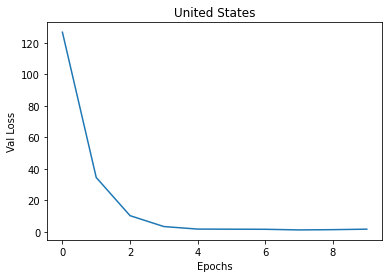

In [91]:
plt.plot(history.history['val_loss'])
plt.title('United States');
plt.xlabel("Epochs");
plt.ylabel("Val Loss");

In [15]:
model1 = load_model('us_model/')
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals':y_train})
# train_results

70/70 [==============================] - 1s 3ms/step


In [16]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals':y_test})
test_results["Difference"] = abs(test_results["Actuals"] - test_results["Test Predictions"])
# test_results
united_states_average_accuracy = test_results["Difference"].mean()
print("On Average, the mean difference between our predictions and actuals for our", len(test_results), "test data points is:", united_states_average_accuracy)

5/5 [==============================] - 0s 4ms/step
On Average, the mean difference between our predictions and actuals for our 145 test data points is: 0.9105472195855504


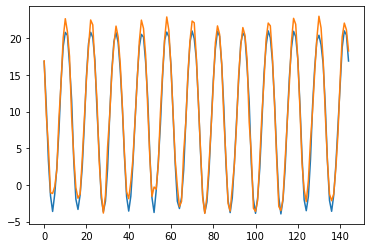

In [17]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

# Afghanistan

In [18]:
afghanistan_final, afghanistan_final_temp_only = clean_df(afghanistan)
# united_states_final.head()
WINDOW_SIZE = 5
afghanistan_X, afghanistan_y = df_to_X_y(afghanistan_final_temp_only, WINDOW_SIZE)
afghanistan_X.shape, afghanistan_y.shape

((2080, 5, 1), (2080,))

In [19]:
afghanistan_train_len, afghanistan_val_len, afghanistan_test_len = get_lengths(afghanistan_final_temp_only)
print(afghanistan_train_len, afghanistan_val_len, afghanistan_test_len)
afghanistan_X_train, afghanistan_y_train = afghanistan_X[:afghanistan_train_len], afghanistan_y[:afghanistan_train_len]
afghanistan_X_val, afghanistan_y_val = afghanistan_X[afghanistan_train_len:(afghanistan_val_len+afghanistan_train_len)], afghanistan_y[afghanistan_train_len:(afghanistan_val_len+afghanistan_train_len)]
afghanistan_X_test, afghanistan_y_test = afghanistan_X[(afghanistan_val_len+afghanistan_train_len):], afghanistan_y[(afghanistan_val_len+afghanistan_train_len):]
afghanistan_X_train.shape, afghanistan_y_train.shape, afghanistan_X_val.shape, afghanistan_y_val.shape, afghanistan_X_test.shape, afghanistan_y_test.shape

1876 83 125


((1876, 5, 1), (1876,), (83, 5, 1), (83,), (121, 5, 1), (121,))

In [20]:
afghan_model = Sequential()
afghan_model.add(InputLayer((5,1)))
afghan_model.add(LSTM(64))
afghan_model.add(Dense(8, 'relu'))
afghan_model.add(Dense(1, 'linear'))

afghan_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [21]:
afghan_cp = ModelCheckpoint('afghan_model/', save_best_only=True)
afghan_history = History()
afghan_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [22]:
afghan_model.fit(afghanistan_X_train, afghanistan_y_train, validation_data=(afghanistan_X_val, afghanistan_y_val), epochs=10, callbacks=[afghan_cp, afghan_history])

Epoch 1/10
53/59 [=========================>....] - ETA: 0s - loss: 216.6910 - root_mean_squared_error: 14.7204

59/59 [==============================] - 8s 106ms/step - loss: 210.5318 - root_mean_squared_error: 14.5097 - val_loss: 158.1759 - val_root_mean_squared_error: 12.5768
Epoch 2/10
52/59 [=========================>....] - ETA: 0s - loss: 106.7526 - root_mean_squared_error: 10.3321

59/59 [==============================] - 5s 89ms/step - loss: 103.0218 - root_mean_squared_error: 10.1500 - val_loss: 76.1314 - val_root_mean_squared_error: 8.7253
Epoch 3/10
53/59 [=========================>....] - ETA: 0s - loss: 55.3865 - root_mean_squared_error: 7.4422

59/59 [==============================] - 6s 102ms/step - loss: 53.9276 - root_mean_squared_error: 7.3435 - val_loss: 39.3633 - val_root_mean_squared_error: 6.2740
Epoch 4/10
55/59 [==========================>...] - ETA: 0s - loss: 25.2505 - root_mean_squared_error: 5.0250

59/59 [==============================] - 5s 93ms/step - loss: 24.6546 - root_mean_squared_error: 4.9653 - val_loss: 15.5739 - val_root_mean_squared_error: 3.9464
Epoch 5/10
53/59 [=========================>....] - ETA: 0s - loss: 8.0122 - root_mean_squared_error: 2.8306

59/59 [==============================] - 5s 89ms/step - loss: 7.6543 - root_mean_squared_error: 2.7666 - val_loss: 4.3726 - val_root_mean_squared_error: 2.0911
Epoch 6/10
56/59 [===========================>..] - ETA: 0s - loss: 2.9154 - root_mean_squared_error: 1.7075

59/59 [==============================] - 6s 104ms/step - loss: 2.8819 - root_mean_squared_error: 1.6976 - val_loss: 2.3894 - val_root_mean_squared_error: 1.5458
Epoch 7/10
59/59 [==============================] - 0s 7ms/step - loss: 2.2938 - root_mean_squared_error: 1.5145 - val_loss: 2.8586 - val_root_mean_squared_error: 1.6907
Epoch 8/10
59/59 [==============================] - 0s 7ms/step - loss: 2.1338 - root_mean_squared_error: 1.4608 - val_loss: 2.4429 - val_root_mean_squared_error: 1.5630
Epoch 9/10
55/59 [==========================>...] - ETA: 0s - loss: 2.0933 - root_mean_squared_error: 1.4468

59/59 [==============================] - 5s 88ms/step - loss: 2.0970 - root_mean_squared_error: 1.4481 - val_loss: 1.8342 - val_root_mean_squared_error: 1.3543
Epoch 10/10
59/59 [==============================] - 0s 7ms/step - loss: 2.0589 - root_mean_squared_error: 1.4349 - val_loss: 2.1109 - val_root_mean_squared_error: 1.4529


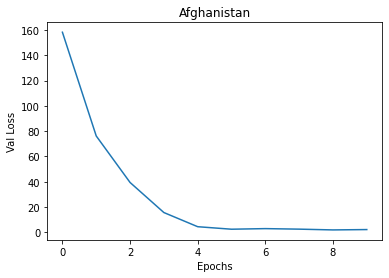

In [99]:
plt.plot(afghan_history.history['val_loss'])
plt.title('Afghanistan');
plt.xlabel("Epochs");
plt.ylabel("Val Loss");

In [24]:
afghan_model = load_model('afghan_model/')
afghan_train_predictions = afghan_model.predict(afghanistan_X_train).flatten()
afghan_train_results = pd.DataFrame(data={'Train Predictions': afghan_train_predictions, 'Actuals':afghanistan_y_train})
# afghan_train_results

59/59 [==============================] - 1s 3ms/step


In [25]:
afghan_test_predictions = afghan_model.predict(afghanistan_X_test).flatten()
afghan_test_results = pd.DataFrame(data={'Test Predictions': afghan_test_predictions, 'Actuals':afghanistan_y_test})
afghan_test_results["Difference"] = abs(afghan_test_results["Actuals"] - afghan_test_results["Test Predictions"])
afghan_average_accuracy = afghan_test_results["Difference"].mean()
print("On Average, the mean difference between our predictions and actuals for our", len(afghan_test_results), "test data points is:", afghan_average_accuracy)

4/4 [==============================] - 0s 4ms/step
On Average, the mean difference between our predictions and actuals for our 121 test data points is: 1.3514688331588245


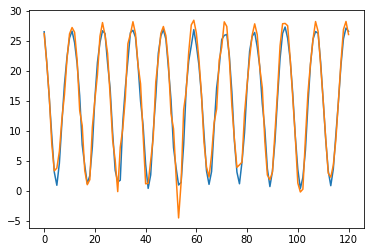

In [26]:
plt.plot(afghan_test_results['Test Predictions'])
plt.plot(afghan_test_results['Actuals'])

# Bangladesh

In [27]:
bangladesh_final, bangladesh_final_temp_only = clean_df(bangladesh)
# bangladesh_final.head()
WINDOW_SIZE = 5
bangladesh_X, bangladesh_y = df_to_X_y(bangladesh_final_temp_only, WINDOW_SIZE)
bangladesh_X.shape, bangladesh_y.shape

((2524, 5, 1), (2524,))

In [28]:
bangladesh_train_len, bangladesh_val_len, bangladesh_test_len = get_lengths(bangladesh_final_temp_only)
print(bangladesh_train_len, bangladesh_val_len, bangladesh_test_len)
bangladesh_X_train, bangladesh_y_train = bangladesh_X[:bangladesh_train_len], bangladesh_y[:bangladesh_train_len]
bangladesh_X_val, bangladesh_y_val = bangladesh_X[bangladesh_train_len:(bangladesh_val_len+bangladesh_train_len)], bangladesh_y[bangladesh_train_len:(bangladesh_val_len+bangladesh_train_len)]
bangladesh_X_test, bangladesh_y_test = bangladesh_X[(bangladesh_val_len+bangladesh_train_len):], bangladesh_y[(bangladesh_val_len+bangladesh_train_len):]
bangladesh_X_train.shape, bangladesh_y_train.shape, bangladesh_X_val.shape, bangladesh_y_val.shape, bangladesh_X_test.shape, bangladesh_y_test.shape

2276 101 151


((2276, 5, 1), (2276,), (101, 5, 1), (101,), (147, 5, 1), (147,))

In [29]:
bangladesh_model = Sequential()
bangladesh_model.add(InputLayer((5,1)))
bangladesh_model.add(LSTM(64))
bangladesh_model.add(Dense(8, 'relu'))
bangladesh_model.add(Dense(1, 'linear'))

bangladesh_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [30]:
bangladesh_cp = ModelCheckpoint('bangladesh_model/', save_best_only=True)
bangladesh_history = History()
bangladesh_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [31]:
bangladesh_model.fit(bangladesh_X_train, bangladesh_y_train, validation_data=(bangladesh_X_val, bangladesh_y_val), epochs=10, callbacks=[bangladesh_cp, bangladesh_history])

Epoch 1/10
68/72 [===========================>..] - ETA: 0s - loss: 503.7408 - root_mean_squared_error: 22.4442

72/72 [==============================] - 9s 89ms/step - loss: 495.5330 - root_mean_squared_error: 22.2606 - val_loss: 339.4177 - val_root_mean_squared_error: 18.4233
Epoch 2/10
68/72 [===========================>..] - ETA: 0s - loss: 179.1049 - root_mean_squared_error: 13.3830

72/72 [==============================] - 5s 75ms/step - loss: 174.0399 - root_mean_squared_error: 13.1924 - val_loss: 57.4607 - val_root_mean_squared_error: 7.5803
Epoch 3/10
69/72 [===========================>..] - ETA: 0s - loss: 24.5749 - root_mean_squared_error: 4.9573

72/72 [==============================] - 5s 75ms/step - loss: 24.2751 - root_mean_squared_error: 4.9270 - val_loss: 14.8347 - val_root_mean_squared_error: 3.8516
Epoch 4/10
70/72 [============================>.] - ETA: 0s - loss: 14.7194 - root_mean_squared_error: 3.8366

72/72 [==============================] - 6s 91ms/step - loss: 14.7051 - root_mean_squared_error: 3.8347 - val_loss: 14.2062 - val_root_mean_squared_error: 3.7691
Epoch 5/10
72/72 [==============================] - 1s 7ms/step - loss: 14.6585 - root_mean_squared_error: 3.8286 - val_loss: 14.2105 - val_root_mean_squared_error: 3.7697
Epoch 6/10
65/72 [==========================>...] - ETA: 0s - loss: 14.0823 - root_mean_squared_error: 3.7526

72/72 [==============================] - 5s 74ms/step - loss: 13.9790 - root_mean_squared_error: 3.7389 - val_loss: 12.8768 - val_root_mean_squared_error: 3.5884
Epoch 7/10
71/72 [============================>.] - ETA: 0s - loss: 11.9631 - root_mean_squared_error: 3.4588

72/72 [==============================] - 5s 74ms/step - loss: 11.9697 - root_mean_squared_error: 3.4597 - val_loss: 10.7395 - val_root_mean_squared_error: 3.2771
Epoch 8/10
71/72 [============================>.] - ETA: 0s - loss: 9.9553 - root_mean_squared_error: 3.1552 

72/72 [==============================] - 6s 87ms/step - loss: 9.9521 - root_mean_squared_error: 3.1547 - val_loss: 8.7888 - val_root_mean_squared_error: 2.9646
Epoch 9/10
67/72 [==========================>...] - ETA: 0s - loss: 8.1063 - root_mean_squared_error: 2.8472

72/72 [==============================] - 5s 75ms/step - loss: 8.0882 - root_mean_squared_error: 2.8440 - val_loss: 7.3457 - val_root_mean_squared_error: 2.7103
Epoch 10/10
72/72 [==============================] - 6s 85ms/step - loss: 6.6977 - root_mean_squared_error: 2.5880 - val_loss: 6.1103 - val_root_mean_squared_error: 2.4719


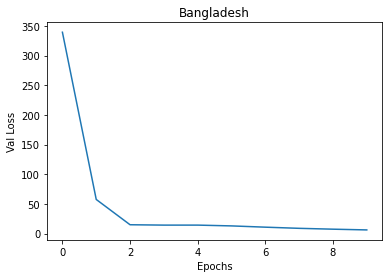

In [95]:
plt.plot(bangladesh_history.history['val_loss'])
plt.title('Bangladesh');
plt.xlabel("Epochs");
plt.ylabel("Val Loss");

In [33]:
bangladesh_model = load_model('bangladesh_model/')
bangladesh_train_predictions = bangladesh_model.predict(bangladesh_X_train).flatten()
bangladesh_train_results = pd.DataFrame(data={'Train Predictions': bangladesh_train_predictions, 'Actuals':bangladesh_y_train})
# afghan_train_results

72/72 [==============================] - 1s 3ms/step


In [34]:
bangladesh_test_predictions = bangladesh_model.predict(bangladesh_X_test).flatten()
bangladesh_test_results = pd.DataFrame(data={'Test Predictions': bangladesh_test_predictions, 'Actuals':bangladesh_y_test})
bangladesh_test_results["Difference"] = abs(bangladesh_test_results["Actuals"] - bangladesh_test_results["Test Predictions"])
bangladesh_average_accuracy = bangladesh_test_results["Difference"].mean()
print("On Average, the mean difference between our predictions and actuals for our", len(bangladesh_test_results), "test data points is:", bangladesh_average_accuracy)

5/5 [==============================] - 0s 4ms/step
On Average, the mean difference between our predictions and actuals for our 147 test data points is: 2.2708936546481393


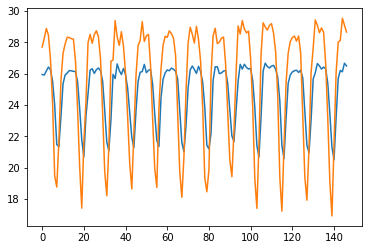

In [35]:
plt.plot(bangladesh_test_results['Test Predictions'])
plt.plot(bangladesh_test_results['Actuals'])

# Chad

In [36]:
chad_final, chad_final_temp_only = clean_df(chad)
# chad_final.head()
WINDOW_SIZE = 5
chad_X, chad_y = df_to_X_y(chad_final_temp_only, WINDOW_SIZE)
chad_X.shape, chad_y.shape

((1730, 5, 1), (1730,))

In [37]:
chad_train_len, chad_val_len, chad_test_len = get_lengths(chad_final_temp_only)
print(chad_train_len, chad_val_len, chad_test_len)
chad_X_train, chad_y_train = chad_X[:chad_train_len], chad_y[:chad_train_len]
chad_X_val, chad_y_val = chad_X[chad_train_len:(chad_val_len+chad_train_len)], chad_y[chad_train_len:(chad_val_len+chad_train_len)]
chad_X_test, chad_y_test = chad_X[(chad_val_len+chad_train_len):], chad_y[(chad_val_len+chad_train_len):]
chad_X_train.shape, chad_y_train.shape, chad_X_val.shape, chad_y_val.shape, chad_X_test.shape, chad_y_test.shape

1561 69 104


((1561, 5, 1), (1561,), (69, 5, 1), (69,), (100, 5, 1), (100,))

In [38]:
chad_model = Sequential()
chad_model.add(InputLayer((5,1)))
chad_model.add(LSTM(64))
chad_model.add(Dense(8, 'relu'))
chad_model.add(Dense(1, 'linear'))
chad_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [39]:
chad_cp = ModelCheckpoint('chad_model/', save_best_only=True)
chad_history = History()
chad_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [40]:
chad_model.fit(chad_X_train, chad_y_train, validation_data=(chad_X_val, chad_y_val), epochs=10, callbacks=[chad_cp, chad_history])

Epoch 1/10
49/49 [==============================] - ETA: 0s - loss: 743.0139 - root_mean_squared_error: 27.2583

49/49 [==============================] - 9s 136ms/step - loss: 743.0139 - root_mean_squared_error: 27.2583 - val_loss: 773.8051 - val_root_mean_squared_error: 27.8174
Epoch 2/10
45/49 [==========================>...] - ETA: 0s - loss: 737.0035 - root_mean_squared_error: 27.1478

49/49 [==============================] - 5s 107ms/step - loss: 737.3723 - root_mean_squared_error: 27.1546 - val_loss: 771.1086 - val_root_mean_squared_error: 27.7688
Epoch 3/10
43/49 [=========================>....] - ETA: 0s - loss: 736.9391 - root_mean_squared_error: 27.1466

49/49 [==============================] - 5s 106ms/step - loss: 734.7396 - root_mean_squared_error: 27.1061 - val_loss: 768.4163 - val_root_mean_squared_error: 27.7203
Epoch 4/10
41/49 [========================>.....] - ETA: 0s - loss: 733.5040 - root_mean_squared_error: 27.0833

49/49 [==============================] - 6s 124ms/step - loss: 732.1124 - root_mean_squared_error: 27.0576 - val_loss: 765.7320 - val_root_mean_squared_error: 27.6719
Epoch 5/10
44/49 [=========================>....] - ETA: 0s - loss: 729.6349 - root_mean_squared_error: 27.0118

49/49 [==============================] - 5s 103ms/step - loss: 729.4919 - root_mean_squared_error: 27.0091 - val_loss: 763.0565 - val_root_mean_squared_error: 27.6235
Epoch 6/10
43/49 [=========================>....] - ETA: 0s - loss: 726.0464 - root_mean_squared_error: 26.9452

49/49 [==============================] - 5s 104ms/step - loss: 726.8787 - root_mean_squared_error: 26.9607 - val_loss: 760.3852 - val_root_mean_squared_error: 27.5751
Epoch 7/10
44/49 [=========================>....] - ETA: 0s - loss: 726.1503 - root_mean_squared_error: 26.9472

49/49 [==============================] - 6s 127ms/step - loss: 724.2725 - root_mean_squared_error: 26.9123 - val_loss: 757.7181 - val_root_mean_squared_error: 27.5267
Epoch 8/10
42/49 [========================>.....] - ETA: 0s - loss: 721.5945 - root_mean_squared_error: 26.8625

49/49 [==============================] - 5s 106ms/step - loss: 721.6716 - root_mean_squared_error: 26.8639 - val_loss: 755.0629 - val_root_mean_squared_error: 27.4784
Epoch 9/10
42/49 [========================>.....] - ETA: 0s - loss: 719.5782 - root_mean_squared_error: 26.8250

49/49 [==============================] - 5s 105ms/step - loss: 719.0786 - root_mean_squared_error: 26.8156 - val_loss: 752.4131 - val_root_mean_squared_error: 27.4301
Epoch 10/10
42/49 [========================>.....] - ETA: 0s - loss: 717.2720 - root_mean_squared_error: 26.7819

49/49 [==============================] - 6s 126ms/step - loss: 716.4928 - root_mean_squared_error: 26.7674 - val_loss: 749.7684 - val_root_mean_squared_error: 27.3819


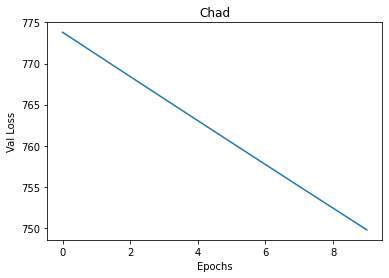

In [97]:
plt.plot(chad_history.history['val_loss'])
plt.title('Chad');
plt.xlabel("Epochs");
plt.ylabel("Val Loss");

In [42]:
chad_model = load_model('chad_model/')
chad_train_predictions = chad_model.predict(chad_X_train).flatten()
chad_train_results = pd.DataFrame(data={'Train Predictions': chad_train_predictions, 'Actuals':chad_y_train})
# afghan_train_results

49/49 [==============================] - 1s 3ms/step


In [43]:
chad_test_predictions = chad_model.predict(chad_X_test).flatten()
chad_test_results = pd.DataFrame(data={'Test Predictions':chad_test_predictions, 'Actuals':chad_y_test})
chad_test_results["Difference"] = abs(chad_test_results["Actuals"] - chad_test_results["Test Predictions"])
chad_average_accuracy = chad_test_results["Difference"].mean()
print("On Average, the mean difference between our predictions and actuals for our", len(chad_test_results), "test data points is:", chad_average_accuracy)

4/4 [==============================] - 0s 4ms/step
On Average, the mean difference between our predictions and actuals for our 100 test data points is: 27.607275671653746


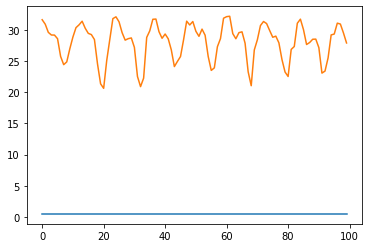

In [44]:
plt.plot(chad_test_results['Test Predictions'])
plt.plot(chad_test_results['Actuals'])

 # Haiti

In [45]:
haiti_final, haiti_final_temp_only = clean_df(haiti)
# haiti_final.head()
WINDOW_SIZE = 5
haiti_X, haiti_y = df_to_X_y(haiti_final_temp_only, WINDOW_SIZE)
haiti_X.shape, haiti_y.shape

((2226, 5, 1), (2226,))

In [46]:
haiti_train_len, haiti_val_len, haiti_test_len = get_lengths(haiti_final_temp_only)
print(haiti_train_len, haiti_val_len, haiti_test_len)
haiti_X_train, haiti_y_train = haiti_X[:haiti_train_len], haiti_y[:haiti_train_len]
haiti_X_val, haiti_y_val = haiti_X[haiti_train_len:(haiti_val_len+haiti_train_len)], haiti_y[haiti_train_len:(haiti_val_len+haiti_train_len)]
haiti_X_test, haiti_y_test = haiti_X[(haiti_val_len+haiti_train_len):], haiti_y[(haiti_val_len+haiti_train_len):]
haiti_X_train.shape, haiti_y_train.shape, haiti_X_val.shape, haiti_y_val.shape, haiti_X_test.shape, haiti_y_test.shape

2007 89 133


((2007, 5, 1), (2007,), (89, 5, 1), (89,), (130, 5, 1), (130,))

In [47]:
haiti_model = Sequential()
haiti_model.add(InputLayer((5,1)))
haiti_model.add(LSTM(64))
haiti_model.add(Dense(8, 'relu'))
haiti_model.add(Dense(1, 'linear'))
haiti_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [48]:
haiti_cp = ModelCheckpoint('haiti_model/', save_best_only=True)
haiti_history = History()
haiti_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [49]:
haiti_model.fit(haiti_X_train, haiti_y_train, validation_data=(haiti_X_val, haiti_y_val), epochs=10, callbacks=[haiti_cp, haiti_history])

Epoch 1/10
60/63 [===========================>..] - ETA: 0s - loss: 664.9655 - root_mean_squared_error: 25.7869

63/63 [==============================] - 9s 105ms/step - loss: 663.0160 - root_mean_squared_error: 25.7491 - val_loss: 652.3899 - val_root_mean_squared_error: 25.5419
Epoch 2/10
57/63 [==========================>...] - ETA: 0s - loss: 522.2812 - root_mean_squared_error: 22.8535

63/63 [==============================] - 5s 85ms/step - loss: 512.0654 - root_mean_squared_error: 22.6289 - val_loss: 429.6984 - val_root_mean_squared_error: 20.7292
Epoch 3/10
60/63 [===========================>..] - ETA: 0s - loss: 280.5619 - root_mean_squared_error: 16.7500

63/63 [==============================] - 5s 85ms/step - loss: 275.7572 - root_mean_squared_error: 16.6059 - val_loss: 190.2601 - val_root_mean_squared_error: 13.7935
Epoch 4/10
56/63 [=========================>....] - ETA: 0s - loss: 103.5144 - root_mean_squared_error: 10.1742

63/63 [==============================] - 6s 103ms/step - loss: 97.7348 - root_mean_squared_error: 9.8861 - val_loss: 56.7888 - val_root_mean_squared_error: 7.5358
Epoch 5/10
59/63 [===========================>..] - ETA: 0s - loss: 22.4803 - root_mean_squared_error: 4.7413

63/63 [==============================] - 5s 86ms/step - loss: 21.6411 - root_mean_squared_error: 4.6520 - val_loss: 12.6409 - val_root_mean_squared_error: 3.5554
Epoch 6/10
61/63 [============================>.] - ETA: 0s - loss: 4.0200 - root_mean_squared_error: 2.0050

63/63 [==============================] - 5s 85ms/step - loss: 3.9839 - root_mean_squared_error: 1.9960 - val_loss: 4.1646 - val_root_mean_squared_error: 2.0407
Epoch 7/10
58/63 [==========================>...] - ETA: 0s - loss: 1.9487 - root_mean_squared_error: 1.3959

63/63 [==============================] - 6s 103ms/step - loss: 1.9582 - root_mean_squared_error: 1.3994 - val_loss: 2.8832 - val_root_mean_squared_error: 1.6980
Epoch 8/10
63/63 [==============================] - ETA: 0s - loss: 1.8389 - root_mean_squared_error: 1.3561

63/63 [==============================] - 7s 107ms/step - loss: 1.8389 - root_mean_squared_error: 1.3561 - val_loss: 2.6752 - val_root_mean_squared_error: 1.6356
Epoch 9/10
57/63 [==========================>...] - ETA: 0s - loss: 1.8209 - root_mean_squared_error: 1.3494

63/63 [==============================] - 5s 86ms/step - loss: 1.8346 - root_mean_squared_error: 1.3545 - val_loss: 2.6488 - val_root_mean_squared_error: 1.6275
Epoch 10/10
58/63 [==========================>...] - ETA: 0s - loss: 1.8413 - root_mean_squared_error: 1.3569

63/63 [==============================] - 5s 84ms/step - loss: 1.8349 - root_mean_squared_error: 1.3546 - val_loss: 2.6196 - val_root_mean_squared_error: 1.6185


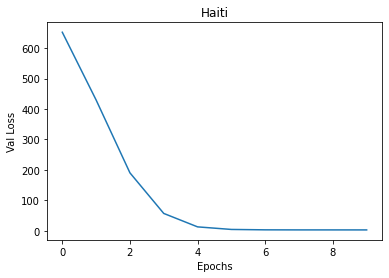

In [98]:
plt.plot(haiti_history.history['val_loss'])
plt.title('Haiti');
plt.xlabel("Epochs");
plt.ylabel("Val Loss");


In [51]:
haiti_model = load_model('haiti_model/')
haiti_train_predictions = haiti_model.predict(haiti_X_train).flatten()
haiti_train_results = pd.DataFrame(data={'Train Predictions': haiti_train_predictions, 'Actuals':haiti_y_train})
# afghan_train_results

63/63 [==============================] - 1s 3ms/step


In [52]:
haiti_test_predictions = haiti_model.predict(haiti_X_test).flatten()
haiti_test_results = pd.DataFrame(data={'Test Predictions':haiti_test_predictions, 'Actuals':haiti_y_test})
haiti_test_results["Difference"] = abs(haiti_test_results["Actuals"] - haiti_test_results["Test Predictions"])
# haiti_test_results
haiti_average_accuracy = haiti_test_results["Difference"].mean()
print("On Average, the mean difference between our predictions and actuals for our", len(haiti_test_results), "test data points is:", haiti_average_accuracy)

5/5 [==============================] - 0s 5ms/step
On Average, the mean difference between our predictions and actuals for our 130 test data points is: 1.3261295025165265


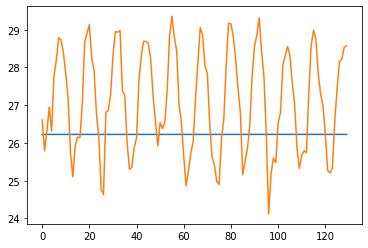

In [53]:
plt.plot(haiti_test_results['Test Predictions'])
plt.plot(haiti_test_results['Actuals'])

# Results

In [76]:
# us_dates = united_states.iloc[-145:]
# us_dates = us_dates[["dt", "AverageTemperature"]]
# us_dates = us_dates.rename(columns={'AverageTemperature': 'Actuals'})
# # us_dates
# test = pd.merge(test_results, us_dates, on='Actuals', how='outer')
# test

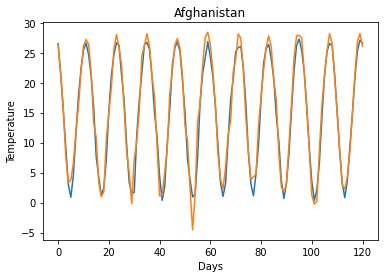

In [101]:
plt.plot(afghan_test_results['Test Predictions'])
plt.plot(afghan_test_results['Actuals'])
plt.title("Afghanistan");
plt.xlabel("Days");
plt.ylabel("Temperature");

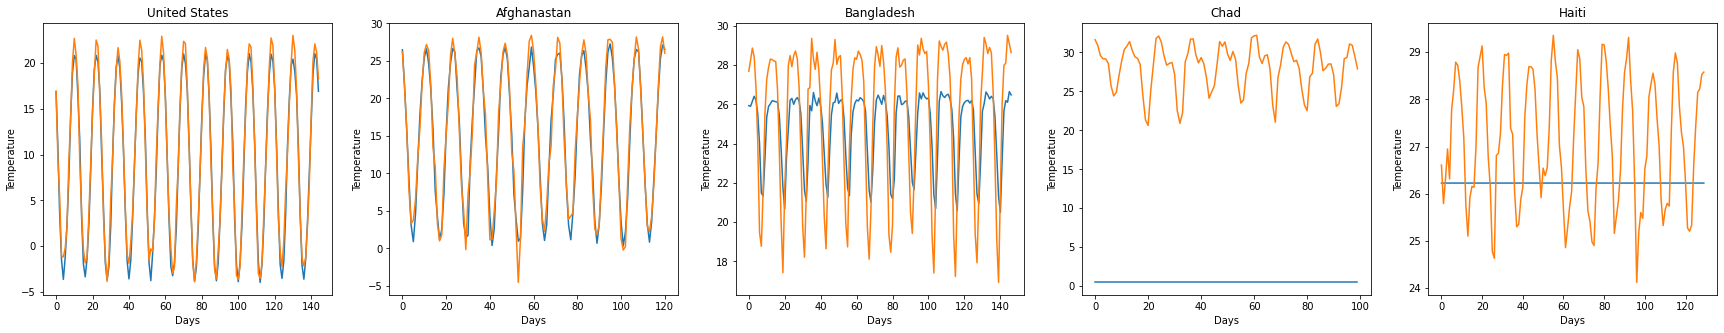

In [77]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30, 5))
ax1.plot(test_results['Test Predictions']);
ax1.plot(test_results['Actuals']);
ax1.set_title("United States");
ax1.set_ylabel("Temperature");
ax1.set_xlabel("Days");
ax2.plot(afghan_test_results['Test Predictions']);
ax2.plot(afghan_test_results['Actuals']);
ax2.set_title("Afghanastan");
ax2.set_ylabel("Temperature");
ax2.set_xlabel("Days");
ax3.plot(bangladesh_test_results['Test Predictions']);
ax3.plot(bangladesh_test_results['Actuals']);
ax3.set_title("Bangladesh");
ax3.set_ylabel("Temperature");
ax3.set_xlabel("Days");
ax4.plot(chad_test_results['Test Predictions']);
ax4.plot(chad_test_results['Actuals']);
ax4.set_title("Chad");
ax4.set_ylabel("Temperature");
ax4.set_xlabel("Days");
ax5.plot(haiti_test_results['Test Predictions']);
ax5.plot(haiti_test_results['Actuals']);
ax5.set_title("Haiti");
ax5.set_ylabel("Temperature");
ax5.set_xlabel("Days");
